## Data synthesis for my trigger word project

For this particular project, I am trying to create a model which will detect my trigger word "toshi" which is the name of my dog. In order to synthesize data for training, I use 10 second clips of background noise and I input a series of negative and positive words. My positive words are randomly sampled from 20 recordings of me saying "toshi" in different ways. The negative words are a series of clips of random other words being spoken by me. The background noise comprises of recording of background noises within my room (where I will be testing the model). All of these recordings are done with quicktime and have the same sampling rate.

I currently have a folder of background recordings which holds a single recording, a folder of 20 trigger word recordings, and a folder of around 72 negative word recordings. My goal is to build a low bias model given the extremely small amount of collected data. The training input will be 10 seconds and contain a series of trigger and negative words. To demonstrate my model I will be comparing the predictions of where the trigger words are said to where the trigger words are actually said.

In [2]:
import numpy as np
import wave
import pylab
from pydub import AudioSegment
from scipy import signal
import scipy.io.wavfile as wavfile
import os
import IPython
import tensorflow as tf
import matplotlib.pyplot as plt
import latex
import spacy
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
np.random.seed(10)
import keras.backend as k

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Functions to load the audio files

In [3]:
# Loads the audio files from a specific folder as pydub audio_segment objects
def get_audio_from_file(the_dir,folder):
    data = []
    for audio_name in os.listdir(the_dir+folder):
        if ".wav" in audio_name: # valid audio file
            audio = AudioSegment.from_wav(the_dir+folder+audio_name)
            data.append(audio)
            
    return data

In [4]:
# Loads the trigger word, negative word, and background noise .wav files and returns 3 lists
# All lists are comprised of pydub audio_segment objects
def load_audio(the_dir="../../data/trigger_word/"):
    new_background = []
    negative = get_audio_from_file(the_dir,"negative/")
    trigger = get_audio_from_file(the_dir,"toshi/")
    background = get_audio_from_file(the_dir,"background/")
    # making sure all backgrounds are 10 seconds long:
    for back in background:
        init_index = 10000
        while init_index < len(back):
            a_back = back[init_index-10000:init_index]
            new_background.append(a_back)
            init_index += 10000
    
    return new_background,trigger,negative

In [5]:
# Returns a list of spectrograms for a given directory of training data
# Each training example is 10sec and corresponds w/ a spectrogram shape of (118,1402)
def get_spec(the_dir="../../data/trigger_word/training"):
    data = []
    for file in os.listdir(the_dir):
        if ".wav" in file: # getting only training examples
            f_name = the_dir + "/" + file
            _,data = wavfile.read(f_name)
            pxx,_,_,_ = plt.specgram(data[:,0],234,8000,noverlap=120)
            data.append(pxx) # spectrogram for a given audio clip
    
    return data

In [2]:
import numpy as np
import wave
import pylab
from pydub import AudioSegment
from scipy import signal
import scipy.io.wavfile as wavfile
import os
import IPython
import tensorflow as tf
import matplotlib.pyplot as plt
import latex
import spacy
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
np.random.seed(10)
import keras.backend as k

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using TensorFlow backend.


(160000, 2)
(118, 1402)


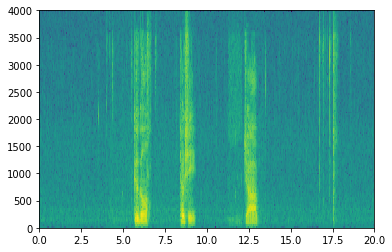

In [5]:
f_name = "../../data/trigger_word/training/train49.wav"
_,data = wavfile.read(f_name)
print(data.shape)
pxx,_,_,_ = plt.specgram(data[:,0],234,8000,noverlap=120)
print(pxx.shape)

In [6]:
# Loading all of the data for creating the training examples
background,trigger,negative = load_audio()

print("number of background examples:",len(background))
print("length of background examples in ms:",len(background[0]))
print("number of trigger word examples:",len(trigger))
print("number of negative word examples:",len(negative))

number of background examples: 65
length of background examples in ms: 10000
number of trigger word examples: 20
number of negative word examples: 72


### Functions to synthesize data

The goal is to create 10 second training examples which consists of trigger and negative word examples being randomly inputted into each training example. At the same time, a 1D y-vector will be created to represent when trigger words are said within the 10 second audio clips. This 1D vector will have a length of 1375 and will be initialized to all zeros. Right after a trigger word is finished being said within the training example, the 50 next values within the 1D vector will be changed to 1, representing that a trigger word has been said.

In [7]:
# Returns a randomly selected time segment for a specific audio to be inputted into the 10s clip
# audio_len: length of audio to input into the 10 second clip, in ms
# returns tuple of segment start and end locations in ms
def get_segment(audio_len):
    seg_start = np.random.randint(0,10000 - audio_len - 5) # dont want any audio right at end of clip
    seg_end = seg_start + audio_len - 1
    return (seg_start,seg_end)

In [8]:
# checks if a given segment overlaps with previous segments for same 10s background segment
# returns true if a given segment overlaps, and false otherwise
def check_overlap(curr_seg,all_segs):
    overlap = False # boolean indicator
    curr_start,curr_end = curr_seg
    
    for aseg in all_segs:
        a_start,a_end = aseg
        if not (curr_start > a_end or curr_end < a_start):
            overlap = True
    
    return overlap

In [9]:
# inserts a audio segment into a 10 second background clip - makes sure there is no overlapping
# updates an inputted background clip by inserting another audio clip and returns new 10s clip
def insert_segment(curr_seg,background,all_segs):
    """
    curr_seg: audio clip to be inserted
    background: 10s clips for curr_seg to be inserted
    all_segs: all previous inserted clips
    """
    len_ms = len(curr_seg) # length of input segment in ms
    new_seg = get_segment(len_ms)
    while check_overlap(new_seg,all_segs): # while there is overlap get new segments
        new_seg = get_segment(len_ms)
        
    all_segs.append(new_seg) # once a non-overlapping segment is found append to previous segs
    new_background = background.overlay(curr_seg,position=new_seg[0]) # overlay on background
    
    return new_background,all_segs # return updated background clip and all segs inserted

In [10]:
# This updates the y-vector when a trigger word has been inputted into a background clip
# this takes in a list of segment ends to be inputted into the y-vector
def insert_ones(all_prev_segs):
    """
    y: 1D vector of shape (1,1375)
    seg_end: end in ms of the input audio clip
    """
    y = np.zeros((1,1375))
    for seg_end in all_prev_segs: # going through all segment ends
        y_start = int(math.ceil(seg_end / 10000 * 1375)) # where first 1 should be in 1375 y vector
        y_end = min(y_start+50,1375)
        while y_start < y_end: # until 50 1s have been added or end of vector has been reached
            y[:,y_start] = 1 
            y_start += 1
    
    return y

In [11]:
# Returns a synthesized training examples consisting of negative and trigger words over background audio
# inserts 0-3 trigger words and 0-2 negative words into the audio clips
# returns the spectogram of the training audio clip and the y-encoding and the name of the file saved
def get_example(trigger,negative,background,ex_no):
    y = np.zeros((1,1375))
    # np.random.seed(1)
    prev_segs = [] # holds all of the segments added
    
    # getting random trigger and negative audio clips
    t_to_add = np.random.randint(0,3) # no. of trigger words to add
    trigger_clips = [trigger[np.random.randint(0,len(trigger))] for i in range(t_to_add)] # trigger words to add
    n_to_add = np.random.randint(0,3) # no. of neg. words to add
    neg_clips = [negative[np.random.randint(0,len(negative))] for i in range(n_to_add)] # neg. words to add
    
    clip_i = np.random.randint(0,len(background)) # get random background clip to use 
    back_clip = background[clip_i]
        
    # Inserting trigger words into background clip
    all_prev_segs = []
    for clip in trigger_clips:
        back_clip,prev_segs = insert_segment(clip,back_clip,prev_segs)
        all_prev_segs.append(prev_segs[-1][1])
    
    y = insert_ones(all_prev_segs)
    
    # Inserting negative word examples into background clip
    for clip in neg_clips:
        back_clip,prev_segs = insert_segment(clip,back_clip,prev_segs)
    
    fname = "../../data/trigger_word/training/train"+str(ex_no)+".wav"
    name = "train"+str(ex_no)
    back_clip.export(fname, format="wav") # saving the clip
    _,data = wavfile.read(fname)
    x,_,_,_ = plt.specgram(data[:,0],234,8000,noverlap=120) # getting spectrogram for clip
    
    return x,y,name

In [12]:
# Makes a determined number of training examples by calling get_example
# returns training set and associated labels
def get_examples(trigger,negative,background,to_make=1000):
    """
    to_make: the number of training examples to make 
    background: list of 10 second long background recordings
    negative: clips of non-trigger words
    trigger: clips of trigger word being said
    """
    x = []
    y = []
    names = []
    
    for ex_no in range(to_make):
        ax,ay,name = get_example(trigger,negative,background,ex_no+1)
        x.append(ax)
        y.append(ay)
        names.append(name)
        
    return x,y,names

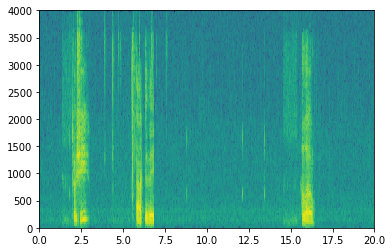

In [13]:
# Getting the training data
x,y,names = get_examples(trigger,negative,background,to_make=1000)

In [14]:
f_name = "../../data/trigger_word/training/train4.wav"
IPython.display.Audio(f_name)

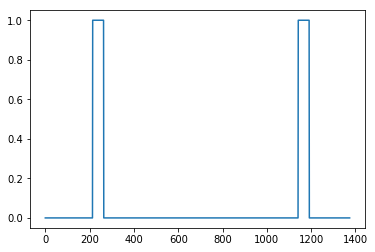

In [15]:
# Example of an encoding
ay1 = y[3]
ay1.shape = (1375)
plt.plot(ay1)
plt.show()

In [16]:
print(len(x))
print(x[0].shape)
print(len(y))
print(y[0].shape)

1000
(118, 1402)
1000
(1, 1375)


In [25]:
for i in range(len(y)):
    y[i].shape = (1375)

In [27]:
x_vec = np.array(x)
y_vec = np.array(y)
y_vec.shape = (1000,1375)
print(x_vec.shape)
print(y_vec.shape)

(1000, 118, 1402)
(1000, 1375)


In [28]:
# Saving data
np.save("../../data/trigger_word/data/x.npy",x_vec)
np.save("../../data/trigger_word/data/y.npy",y_vec)